In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gekko import GEKKO

from scipy.signal import savgol_filter

In [2]:
czantoria_full = pd.read_csv('data/csv/czantoria_sauce.csv')
czantoria_full.columns = ['time', 'distance', 'heartrate', 'cadence', 'velocity_smooth', 'altitude', 'grade_smooth']
czantoria_nonzero = czantoria_full[(czantoria_full['velocity_smooth'] > 0) | (czantoria_full['time'] == 0)]
czantoria_time = czantoria_nonzero.groupby('distance').agg({'time': 'max'}).reset_index()['time']
czantoria_final = pd.merge(czantoria_nonzero, czantoria_time, on=['time'])

In [3]:
distance_data = czantoria_final['distance'].to_numpy()
grade_data = czantoria_final['grade_smooth'].to_numpy()
elevation_data = czantoria_final['altitude'].to_numpy()

In [4]:
grade_smooth = savgol_filter(grade_data, 501, 1)

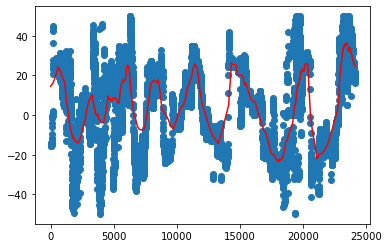

In [5]:
plt.scatter(distance_data, grade_data)
plt.plot(distance_data, grade_smooth, 'r')

In [6]:
# grade_data = np.arctan(grade_data/100)
# yhat = np.arctan(grade_smooth/100)
# plt.scatter(distance_data, grade_data)
# plt.plot(distance_data, yhat, 'r')

In [7]:
grade_data = grade_smooth

print(len(grade_data))

n = distance_data.shape[0]
to_stay = np.zeros(n)
to_stay[0] = 1

for i in range(n - 1):
    if np.abs(grade_data[i+1] - grade_data[i]) < 1.5:
        grade_data[i+1] = grade_data[i]
        to_stay[i+1] = 0
    elif np.sign(grade_data[i+1]) != np.sign(grade_data[i]):
        to_stay[i + 1] = 1
    else:
        to_stay[i + 1] = 1
        
to_stay[-1] = 1

grade_data = grade_data[to_stay == 1]
distance_data = distance_data[to_stay == 1]
elevation_data = elevation_data[to_stay == 1]

print(len(grade_data))

grade_data = np.arctan(grade_data/100)

13385
335


In [8]:
distance = distance_data[-1]

x_data = distance_data/(distance_data[-1])
slope_data = grade_data

# x_data = x_data[x_data <= distance]
# slope_data = slope_data[x_data <= distance]

In [9]:
# create GEKKO model
m = GEKKO()

In [10]:
t_est = 4 * 60 * 60
t_min = 1 * 60 * 60
t_max = 20 * 60 * 60

In [11]:
# constants
N_m = 0.0222
E0 = 1400
X = distance
tau = 0.67
g = 9.81
k = 0.03734
mass = 55
S = 22

In [12]:
# equation parts
alpha = (np.sqrt(S/tau) * X)/E0
beta = (4 * 4184 * 1/75 * N_m * X)/(E0 * np.sqrt(S * tau))
gamma = X/np.sqrt(S * tau**3)
delta = (g*X)/(S*tau)
mu = (k*N_m*X)/(np.sqrt(S*tau))

In [13]:
# scales
u_scale = np.sqrt(S/tau)
v_scale = np.sqrt(S*tau)
t_scale = X/v_scale

In [14]:
# scaled values
sigma0 = 1
e0 = 1
x0 = 0
v0 = 0
n0 = 0.00201818/N_m

e_crit = 0.15 * e0

In [15]:
# sigma data to create spline
E_data = np.linspace(0, e0, 1001)
sigma_data = sigma0 * E_data/(e0 * e_crit) + 0.75 * sigma0 * (1 - E_data/(e0 * e_crit))
sigma_data[E_data > e_crit] = sigma0

# slope data to create spline
# x_data = np.linspace(0, 1, 3000)
# slope_data = np.array(600*[1/18 * np.pi] + 600 * [-1/18 * np.pi] + 600*[1/36 * np.pi] + 600 * [-1/36 * np.pi] + 600 * [1/9 * np.pi])

In [16]:
# time points [s]
nt = 201
tm = np.linspace(0,1,nt)
m.time = tm

In [17]:
# Variables
v = m.Var(value=0.0, lb=0.0, ub=6/v_scale) #velocity
E = m.Var(value=e0, lb=0.0, ub=e0) #energy
x = m.Var(value=0.0) #horizontal coordinate
N = m.Var(value=n0, lb=0.0) # oxidation rate

sigma = m.Var(value=sigma0, lb=0) #breathing rate
slope = m.Var(value=slope_data[0]) #slope

p = np.zeros(nt)
p[-1] = 1.0
final = m.Param(value=p)

In [18]:
# FV - final time
# tf = m.FV(value=t_est/t_scale,lb=t_min/t_scale,ub=t_max/t_scale)
tf = m.FV(value=t_est/t_scale, lb = 0.1)
tf.STATUS = 1

In [19]:
# MV
u = m.MV(value=0,lb=0,ub=9.6/u_scale)
u.STATUS = 1

In [20]:
# energy decrease at the end
m.cspline(E, sigma, E_data, sigma_data, True)

# slope
m.cspline(x, slope, x_data, slope_data, True)

In [21]:
# equations
m.Equation(E.dt()==(alpha * (sigma - u * v) + beta * N)*tf)
m.Equation(v.dt()==(gamma * (u - v) - delta * m.sin(slope)) * tf)
m.Equation(x.dt()==(v*m.cos(slope))*tf)
m.Equation(N.dt()==(mu * N * (1 - N))*tf)
# m.Equation(alpha * (sigma - u * v) + beta * N <= 0)
m.Equation((distance - X*x)*final<=0)

m.fix_final(E, 0)

In [22]:
m.options.IMODE = 6
m.options.MAX_ITER=30000
m.options.SOLVER=3
# m.options.RTOL=1e-4
# m.options.OTOL=1e-4

m.solve()

print('Final Time: ' + str(tf.value[0] * t_scale))

tm = tm * tf.value[0] * t_scale

apm 80.253.213.10_gk_model0 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 1.0.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            2
   Constants    :            0
   Variables    :           10
   Intermediates:            0
   Connections  :            6
   Equations    :            5
   Residuals    :            5
 
 Number of state variables:           3199
 Number of total equations: -         3000
 Number of slack variables: -          200
 ---------------------------------------
 Degrees of freedom       :             -1
 
 * Warning: DOF <= 0
 **********************************************
 Dynamic Control with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  2.4439705e-01 4.94e+03 9.01e+04   2.5 2.41e+05    -  4.17e-04 2.03e-04f  1
  71  2.4689860e-01 4.94e+03 3.11e+05   2.5 3.63e+05    -  2.63e-04 1.30e-04h  1
  72  2.4930115e-01 4.94e+03 1.10e+06   2.5 5.13e+05    -  2.53e-04 1.25e-04h  1
  73  2.7387791e-01 4.93e+03 4.57e+05   2.5 7.11e+04    -  4.35e-05 1.25e-03f  1
  74  2.9208763e-01 4.93e+03 3.03e+05   2.5 8.19e+04    -  1.34e-04 8.89e-04f  1
  75  2.9589007e-01 4.92e+03 2.17e+06   2.5 1.53e+05    -  4.77e-06 1.78e-04f  1
  76  3.1240026e-01 4.92e+03 2.61e+06   2.5 2.67e+04    -  2.02e-05 7.82e-04f  1
  77r 3.1240026e-01 4.92e+03 9.99e+02   1.3 0.00e+00   5.0 0.00e+00 1.69e-07R  2
  78r 3.1404577e-01 3.13e+03 1.03e+03   1.5 2.33e+03    -  9.48e-03 3.26e-03f  1
  79  3.1441114e-01 3.13e+03 1.85e+03   1.8 1.28e+04    -  3.67e-03 1.45e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80r 3.1441114e-01 3.13e+03

 165  6.2050898e+00 5.90e-12 1.04e-04  -8.0 2.01e-02  -2.3 1.00e+00 1.00e+00f  1
 166  6.2037234e+00 2.45e-12 4.86e-01 -11.0 6.04e-02  -2.8 1.00e+00 7.72e-01f  1
 167  6.2027981e+00 2.15e-11 2.67e-01  -9.1 1.81e-01  -3.2 1.00e+00 1.75e-01f  1
 168  6.1997802e+00 4.06e-11 3.48e-01 -11.0 5.44e-01  -3.7 1.00e+00 1.91e-01f  1
 169  6.1979714e+00 7.95e-11 2.32e-01  -9.3 1.63e+00  -4.2 1.00e+00 3.81e-02f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170  6.1921525e+00 2.18e-10 3.25e-01 -11.0 4.90e+00  -4.7 1.00e+00 4.09e-02f  1
 171  6.1733223e+00 2.28e-09 3.10e-01 -11.0 1.47e+01  -5.1 1.00e+00 4.44e-02f  1
 172  6.1673630e+00 2.34e-09 2.30e-01  -8.6 4.41e+01  -5.6 1.00e+00 4.71e-03f  1
 173  6.1106913e+00 2.36e-08 2.66e-01  -9.7 1.32e+02  -6.1 1.00e+00 1.50e-02f  1
 174  6.0084712e+00 1.19e-07 2.92e-01 -10.1 3.96e+02  -6.6 1.00e+00 9.15e-03f  1
 175  5.7094172e+00 1.43e-06 2.14e-01  -9.3 1.18e+03  -7.1 1.00e+00 9.15e-03f  1
 176  5.1043591e+00 7.69e-06

 261  2.5997609e-04 1.29e-02 8.37e-05  -7.4 1.16e+00  -6.9 1.00e+00 1.00e+00h  1
 262  2.5931567e-04 3.20e-03 6.64e-05  -7.4 3.77e-01  -6.5 1.00e+00 1.00e+00h  1
 263  2.5891817e-04 3.92e-03 6.83e-05  -7.4 1.88e-01  -6.1 1.00e+00 1.00e+00h  1
 264  2.5790142e-04 5.20e-03 4.25e-05  -7.4 6.93e-01  -6.6 1.00e+00 1.00e+00h  1
 265  2.5752190e-04 4.35e-04 1.27e-05  -7.4 2.88e-01  -6.1 1.00e+00 1.00e+00h  1
 266  2.5636930e-04 3.84e-03 2.32e-04  -7.4 7.24e-01  -6.6 1.00e+00 1.00e+00h  1
 267  2.5344315e-04 2.93e-02 2.14e-04  -7.4 1.48e+00  -7.1 1.00e+00 1.00e+00h  1
 268  2.5072871e-04 4.45e-02 2.48e-04  -7.4 4.69e+00  -7.6 1.00e+00 3.16e-01h  1
 269  2.4743503e-04 7.97e-02 1.71e-03  -7.4 1.38e+01  -8.0 8.77e-01 2.58e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270  2.4321718e-04 1.71e-01 1.62e-03  -7.4 1.76e+02    -  9.33e-02 7.75e-02h  1
 271  2.4295854e-04 1.71e-01 7.95e-03 -11.0 4.57e+02    -  1.91e-03 2.65e-03h  1
 272  2.4296923e-04 1.70e-01

 354  2.0856655e-04 9.33e-02 4.18e-06  -8.4 2.31e+01    -  1.00e+00 2.50e-01h  2
 355  2.0858303e-04 5.37e-02 2.49e-06  -8.4 6.19e+00    -  1.00e+00 5.00e-01h  2
 356  2.0860077e-04 6.04e-03 1.65e-05  -8.4 1.38e+00  -8.6 1.00e+00 1.00e+00h  1
 357  2.0860425e-04 6.62e-03 4.10e-07  -8.4 2.17e+00    -  1.00e+00 1.00e+00h  1
 358  2.0860728e-04 8.45e-03 2.41e-06  -8.4 2.22e+00    -  1.00e+00 1.00e+00h  1
 359  2.0859135e-04 1.71e-02 9.02e-07  -8.4 3.34e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 360  2.0859067e-04 2.22e-02 2.63e-06  -8.4 5.58e+00    -  9.23e-01 5.00e-01h  2
 361  2.0859228e-04 2.12e-02 1.53e-06  -8.4 5.53e+00    -  7.61e-01 5.00e-01h  2
 362  2.0859042e-04 2.10e-02 2.23e-06  -8.4 1.04e+01    -  7.29e-01 1.39e-01h  3
 363  2.0860353e-04 2.44e-03 1.81e-06  -8.4 1.37e+00    -  1.00e+00 1.00e+00h  1
 364  2.0858910e-04 3.09e-02 1.00e-05  -8.4 4.55e+00  -9.1 6.06e-01 1.00e+00h  1
 365  2.0857727e-04 2.69e-02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 450  2.0594653e-04 1.07e-02 1.25e-05  -9.5 5.33e+00  -8.6 1.00e+00 1.50e-01h  2
 451  2.0594674e-04 4.38e-03 1.60e-07  -9.5 1.75e+00    -  1.00e+00 1.00e+00h  1
 452  2.0594841e-04 5.71e-05 2.41e-07  -9.5 1.21e-01  -8.2 1.00e+00 1.00e+00h  1
 453  2.0595392e-04 4.93e-05 6.21e-07  -9.5 3.80e+00    -  1.00e+00 1.00e+00H  1
 454  2.0583039e-04 3.43e-04 2.48e-06  -9.9 3.78e-01  -8.6 1.00e+00 1.00e+00h  1
 455  2.0581263e-04 1.69e-04 4.38e-08 -10.0 2.92e-01  -8.2 1.00e+00 1.00e+00h  1
 456  2.0580890e-04 1.64e-04 1.30e-08 -10.0 5.34e-01  -8.7 1.00e+00 1.00e+00h  1
 457  2.0580239e-04 7.88e-03 1.01e-06 -10.0 1.85e+00  -9.2 1.00e+00 8.81e-01h  1
 458  2.0580048e-04 7.17e-03 1.06e-06 -10.0 2.38e+01    -  2.81e-01 1.04e-01f  2
 459  2.0580328e-04 5.70e-04 7.10e-07 -10.0 6.33e-01  -8.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 460  2.0580194e-04 4.43e-04

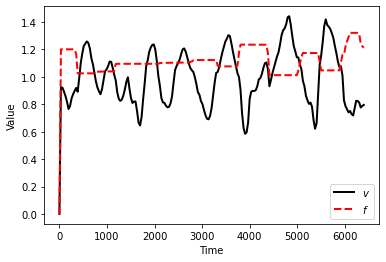

In [23]:
plt.figure(1)
plt.plot(tm,v.value,'k-',lw=2,label=r'$v$')
plt.plot(tm,u.value,'r--',lw=2,label=r'$f$')
plt.legend(loc='best')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

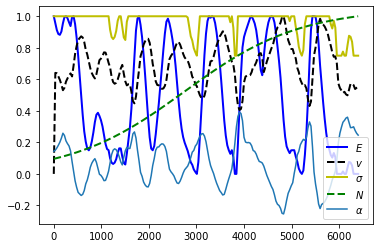

In [24]:
plt.figure(2)
plt.plot(tm,np.array(E.value)/max(E.value),'b-',lw=2,label=r'$E$')
plt.plot(tm,np.array(v.value)/max(v.value),'k--',lw=2,label=r'$v$')
plt.plot(tm, np.array(sigma.value)/max(sigma.value), 'y-', lw=2, label=r'$\sigma$')
plt.plot(tm, np.array(N.value)/max(N.value), 'g--', lw=2, label=r'$N$')
plt.plot(tm,slope, label=r'$\alpha$')
plt.legend()
plt.show()

In [25]:
6281/3600

1.7447222222222223

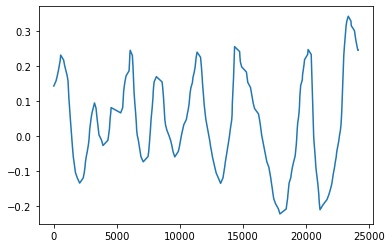

In [26]:
plt.plot(distance_data, grade_data)